## Importing libraries

In [1]:
import pandas as pd
from dotenv import load_dotenv
import os
import pymysql
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

pio.templates.default = "plotly_white"

from datetime import datetime
import warnings
warnings.filterwarnings("ignore") 

In [2]:
## load env
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
load_dotenv(os.path.join(BASE_DIR, '.env'))

True

## Retrieve client data

In [3]:
# find newly added and edited transactions
conn = pymysql.connect(host=os.getenv("MYSQL_DB_HOST") ,
                       port=3306,
                       user=os.getenv("MYSQL_DB_USER"),
                       passwd=os.getenv("MYSQL_DB_PASSWORD"),
                       db=os.getenv("MYSQL_DB_NAME"))

transaction data

In [4]:
query = ("select profileID, transactionDate, transactionAmount,productName  "
        "from depositTransactionsTable dtt "
        "where transactionAmount is not null "
        "and transactionType = 'Deposit' ")

In [5]:
trxn_df = pd.read_sql_query(query, con=conn)

client status data

In [6]:
query = ("select profileID, activeStatus  "
        "from clientTable "
        "where activeStatus = 'Active client'")

In [7]:
client_status_df = pd.read_sql_query(query, con=conn)

filter for only active clients

In [8]:
client_df = trxn_df.merge(client_status_df[["profileID"]],on="profileID")

In [9]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625782 entries, 0 to 625781
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   profileID          625782 non-null  object        
 1   transactionDate    625782 non-null  datetime64[ns]
 2   transactionAmount  625782 non-null  float64       
 3   productName        625782 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 19.1+ MB


## Calculate RFM values

Recency

In [10]:
# recency
client_df['recency'] = (datetime.now().date() - client_df['transactionDate'].dt.date)

In [11]:
# extract days for recency
client_df.recency = client_df.recency.apply(lambda row:str(row).split("days")[0])
client_df.recency = client_df.recency.apply(lambda row:str(row).split("day")[0])

In [12]:
client_df.recency = client_df.recency.astype(int)

frequency

In [13]:
client_df["count"] = 1

In [14]:
frequency_df = client_df.groupby('profileID')['count'].count().reset_index()

In [15]:
frequency_df.rename(columns={'count': 'frequency'}, inplace=True)

In [16]:
client_df = client_df.merge(frequency_df, on='profileID', how='left')

monetary value

In [17]:
monetary_df = client_df.groupby('profileID')['transactionAmount'].sum().reset_index()

In [18]:
monetary_df.rename(columns={'transactionAmount': 'monetaryValue'}, inplace=True)

In [19]:
client_df = client_df.merge(monetary_df, on='profileID', how='left')

## Calculate RFM scores

In [20]:
recency_scores = [5, 4, 3, 2, 1]  # Higher score for lower recency (more recent transactions)
frequency_scores = [1, 2, 3, 4, 5]  # Higher score for higher frequency
monetary_scores = [1, 2, 3, 4, 5]  # Higher score for higher monetary value

# Calculate RFM scores
client_df['recencyScore'] = pd.cut(client_df['recency'], bins=5, labels=recency_scores)
client_df['frequencyScore'] = pd.cut(client_df['frequency'], bins=5, labels=frequency_scores)
client_df['monetaryScore'] = pd.cut(client_df['monetaryValue'], bins=5, labels=monetary_scores)

In [21]:
client_df['recencyScore'] = client_df['recencyScore'].astype(int)
client_df['frequencyScore'] = client_df['frequencyScore'].astype(int)
client_df['monetaryScore'] = client_df['monetaryScore'].astype(int)

## RFM value segmentation

In [22]:
# calc RFM score
client_df['rfmScore'] = client_df['recencyScore'] + client_df['frequencyScore'] + client_df['monetaryScore']

In [23]:
# Create RFM segments based on the RFM score
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
client_df['valueSegment'] = pd.qcut(client_df['rfmScore'], q=3, labels=segment_labels)

In [24]:
client_df = client_df.sort_values(by='transactionDate',ascending=True)

In [25]:
unique_client_df = client_df[['profileID','recency', 'frequency', 
                            'monetaryValue', 'recencyScore','frequencyScore', 
                            'monetaryScore', 'rfmScore', 'valueSegment']].\
                            drop_duplicates(subset=["profileID"],keep='last')

Segment distribution

In [26]:
segment_counts = unique_client_df['valueSegment'].value_counts().reset_index()

In [27]:
segment_counts.columns = ['Value Segment', 'Count']

bar chart

In [28]:
fig = plt.figure(figsize = (10, 5))

<Figure size 1000x500 with 0 Axes>

In [29]:
segments = list(segment_counts["Value Segment"].unique())
segment_values = list(segment_counts["Count"].unique())

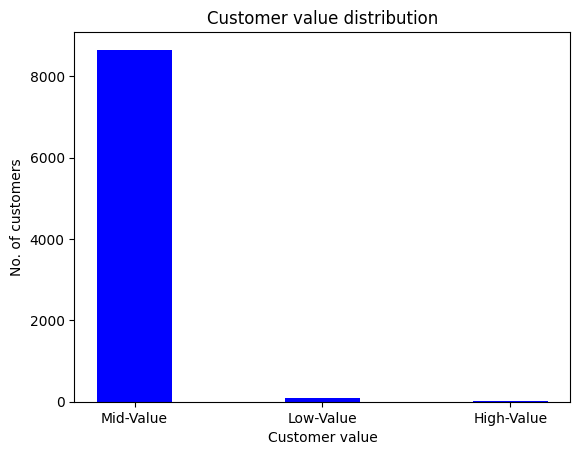

In [30]:
plt.bar(segments, segment_values, color ='blue',
        width = 0.4)
plt.xlabel("Customer value")
plt.ylabel("No. of customers")
plt.title("Customer value distribution")
plt.show()